In [3]:
from basicgeo import P2, P3
from wingshape import WingShape
from parapolygraph import ParamPolyGraph, trimeshesflattener 
import numpy, math

#freecadappimage = "freecad"   # nixos install
freecadappimage = "/home/timbo/software/FreeCAD_0.19-24054-Linux-Conda_glibc2.12-x86_64.AppImage"


In [54]:
import pygmsh

capradius = 1
sphereradius = 2

def meshTruncShphere(truncationx,mesh_size):
    anglestep = 5
    d = 90 - math.degrees(math.asin(truncationx/capradius))
    dsteps = int(2+d*2/anglestep)
    dsteps
    polyloop = [ P2(math.cos(math.radians(a)), math.sin(math.radians(a)))*capradius  for a in numpy.linspace(-d, d, dsteps) ]
    

    with pygmsh.geo.Geometry() as g:
        g.add_polygon(polyloop, mesh_size=mesh_size)
        mesh = g.generate_mesh()

    uvpts = [ P2(p[0], p[1])  for p in mesh.points ]
    pts = [ P3(p[0], p[1], math.sqrt(sphereradius**2 - p.Lensq()))  for p in uvpts ]

    surfacemesh = { "polyloop":polyloop,
                    "uvpts":uvpts, 
                    "pts":numpy.array(pts),
                    "tris":mesh.cells_dict["triangle"],
                  }
    return surfacemesh

def flatSplitSphere(truncationx,mesh_size = 0.05):
    surfacemeshes = [meshTruncShphere(truncationx,mesh_size), meshTruncShphere(-truncationx,mesh_size)]
    trimeshesflattener(surfacemeshes, freecadappimage)
    return surfacemeshes

In [55]:
truncationx = 0.9
surfacemeshes = flatSplitSphere(truncationx,0.1)

>>> >>> >>> >>> >>> >>> >>> >>> >>> ... ... ... ... ... ... ... ... >>> >>> >>> 


[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]
Assembly4 workbench loaded 
mesh (pts=21, tris=20) flattened
mesh (pts=503, tris=933) flattened
[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]



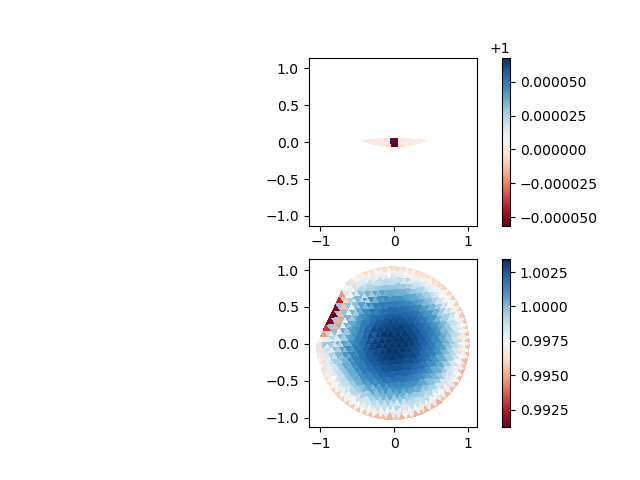

In [56]:
%matplotlib widget
from matplotlib import pyplot as plt

fptsA = surfacemeshes[0]["fpts"]
trisA = surfacemeshes[0]["tris"]
XA = fptsA[:,0]
YA = fptsA[:,1]

fptsB = surfacemeshes[1]["fpts"]
trisB = surfacemeshes[1]["tris"]
XB = fptsB[:,0]
YB = fptsB[:,1]
    
areachangeA = surfacemeshes[0]["triareas"]/surfacemeshes[0]["ftriareas"]
areachangeB = surfacemeshes[1]["triareas"]/surfacemeshes[1]["ftriareas"]
A = plt.subplot(211)
plt.tripcolor(XA, YA, trisA, facecolors=areachangeA, cmap='RdBu')
plt.gca().set_aspect("equal")
plt.colorbar()
plt.subplot(212,sharex = A, sharey =A)
plt.tripcolor(XB, YB, trisB, facecolors=areachangeB, cmap='RdBu')
plt.gca().set_aspect("equal")
plt.colorbar()


In [57]:
def tomWeights(surfacemeshes):
    areas=[]
    fareas=[]
    changes =[]
    weightedChanges = []
    for surfacemesh in surfacemeshes:
        area = numpy.sum(surfacemesh["triareas"])
        farea = numpy.sum(surfacemesh["ftriareas"])
        change = 0
        for i in range(len(surfacemesh["ftriareas"])):
            change = change +abs(surfacemesh["triareas"][i]-surfacemesh["ftriareas"][i])
        areas.append(area)
        fareas.append(farea)
        changes.append(change)
        weightedChanges.append(change/(area))
    return areas,fareas,changes,weightedChanges

In [104]:
def thingGen(mesh_size,truncs):
    thing = {'areas':[],'fareas':[],'changes':[],'weightedChanges':[]}
    for i in truncs:
        print('trunc',i,'mesh_size',mesh_size)
        surfacemeshes = flatSplitSphere(i,mesh_size)
        areas,fareas,changes,weightedChanges = tomWeights(surfacemeshes)
        thing['areas'].append(areas)
        thing['fareas'].append(fareas)
        thing['changes'].append(changes)
        thing['weightedChanges'].append(weightedChanges)
    return thing

In [110]:
things = []
truncs = numpy.arange(-0.9,1,0.1)
mesh_sizes =numpy.arange(0.01,0.1,0.02)
for m in mesh_sizes:
    print('mesh_size:',m)
    t = thingGen(m,truncs)
    things.append(t)
    print(t)

mesh_size: 0.01
trunc -0.9 mesh_size 0.01


/home/timbo/anaconda3/lib/python3.8/site-packages/numpy/ctypeslib.py:517: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)


>>> >>> >>> >>> >>> >>> >>> >>> >>> ... ... ... ... ... ... ... ... >>> >>> >>> 


[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]
Assembly4 workbench loaded 
mesh (pts=38436, tris=76224) flattened
mesh (pts=878, tris=1567) flattened
[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]

trunc -0.8 mesh_size 0.01
>>> >>> >>> >>> >>> >>> >>> >>> >>> ... ... ... ... ... ... ... ... >>> >>> >>> 


[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]
Assembly4 workbench loaded 
mesh (pts=37491, tris=74338) flattened
mesh (pts=2166, tris=4075) flattened
[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]

trunc -0.7000000000000001 mesh_size 0.01
>>> >>> >>> >>> >>> >>> >>> >>> >>> ... ... ... ... ... ... ... ... >>> >>> >>> 


[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]
Assembly4 workbench loaded 
mesh (pts=35156, tris=69681) flattened
mesh (pts=3877, tris=7438) flattened
[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]

trunc -0.6000000000000001 mesh_siz

19
19
19
19
19


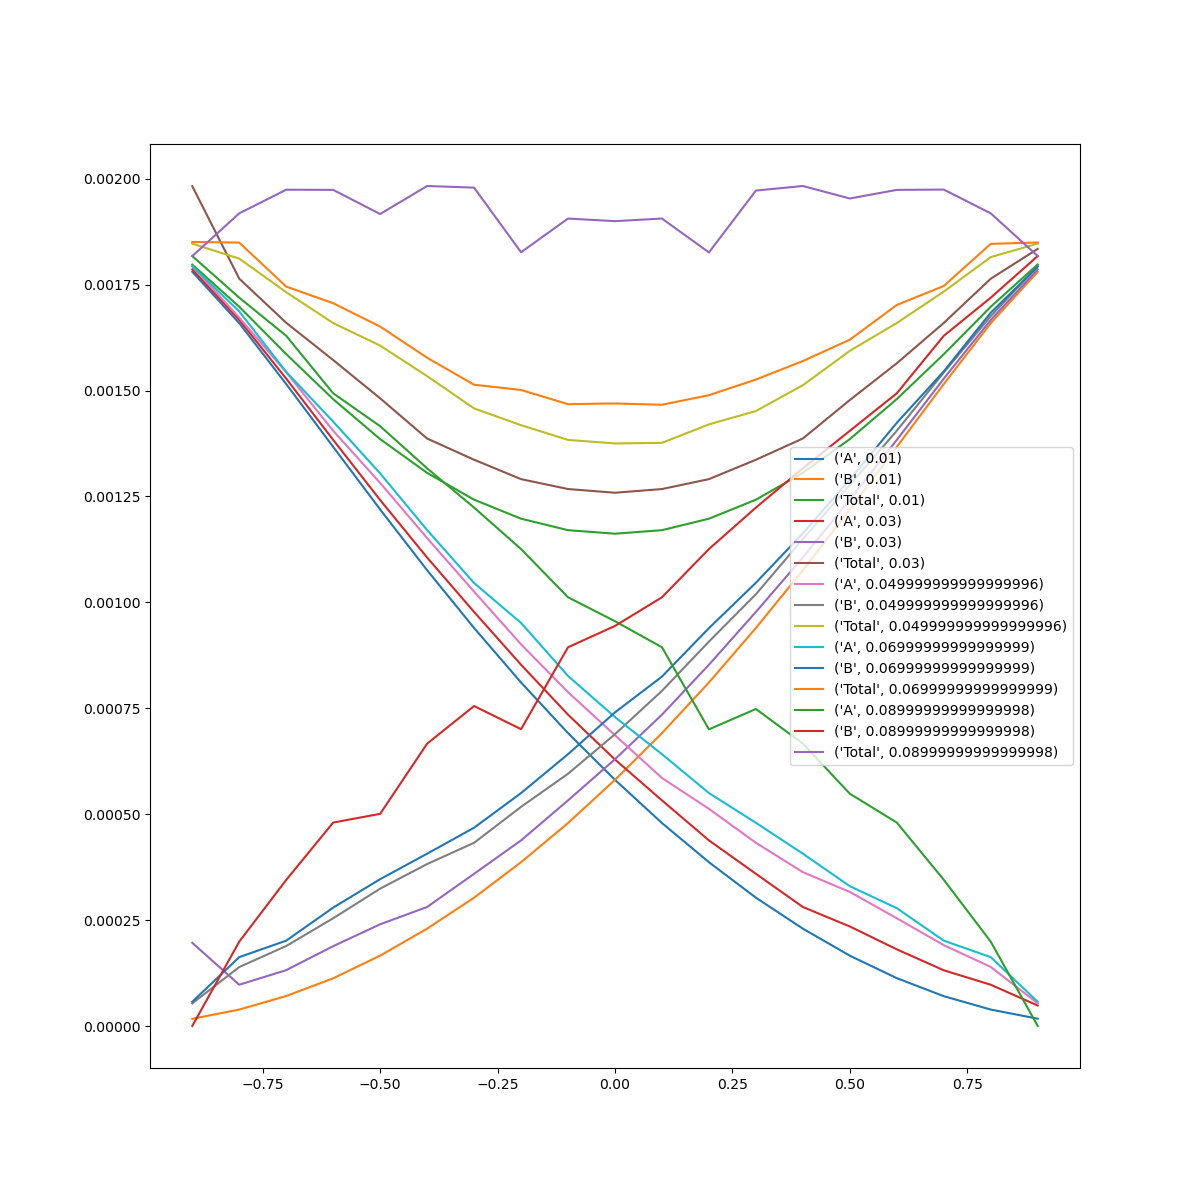

In [112]:
plt.figure(figsize=(12,12))

m=0
for t in things:
    wcA = []
    wcB=[]
    wctot = []
    for wc in t['weightedChanges']:
        
        wcA.append(wc[0])
        wcB.append(wc[1])
        wctot.append(numpy.sum(wc))
    print(len(wcA))
    plt.plot(truncs,wcA,label = ('A',mesh_sizes[m]))
    plt.plot(truncs,wcB,label = ('B',mesh_sizes[m]))
    plt.plot(truncs,wctot,label = ('Total',mesh_sizes[m]))
    m += 1
plt.legend()